In [4]:
from finn.core.datatype import DataType
from driver import FINNExampleOverlay
import time
import os
from PIL import Image
import numpy as np
import cv2
from pynq import Xlnk
import processing as pp
import pynq.ps 
import pymysql

clk = pynq.ps.Clocks

## Instantiate HW Classifier

In [2]:
class_dict = {0: "Correctly Masked", 1: "Incorrectly Worn", 2: "No Mask"}

_bincop_cnv_io_shape_dict = {
    "idt": DataType.UINT8,
    "odt": DataType.UINT8,
    "ishape_normal": (1, 72, 72, 3),
    "oshape_normal": (1, 1),
    "ishape_folded": (1, 1, 72, 72, 1, 3),
    "oshape_folded": (1, 1, 1),
    "ishape_packed": (1, 1, 72, 72, 1, 3),
    "oshape_packed": (1, 1, 1),
}

accel = FINNExampleOverlay("./resizer.bit", "zynq-iodma", _bincop_cnv_io_shape_dict)

In [5]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 72, 72, 3) DataType.UINT8
Expected output shape and datatype: (1, 1) DataType.UINT8


## Run Inference

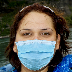

Returned class is: Correctly Masked


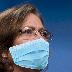

Returned class is: Correctly Masked


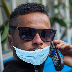

Returned class is: Incorrectly Worn


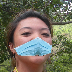

Returned class is: Incorrectly Worn


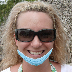

Returned class is: No Mask


In [4]:
im = Image.open('./pictures/1.jpg')
im = pp.resize(im)
accel_in = im.reshape(accel.ishape_normal)
im = Image.fromarray(im, 'RGB')
display(im)
accel_out = accel.execute(accel_in)
print("Returned class is: " + class_dict[int(accel_out)])

im = Image.open('./pictures/2.jpg')
im = pp.resize(im)
accel_in = im.reshape(accel.ishape_normal)
im = Image.fromarray(im, 'RGB')
display(im)
accel_out = accel.execute(accel_in)
print("Returned class is: " + class_dict[int(accel_out)])

im = Image.open('./pictures/3.jpg')
im = pp.resize(im)
accel_in = im.reshape(accel.ishape_normal)
im = Image.fromarray(im, 'RGB')
display(im)
accel_out = accel.execute(accel_in)
print("Returned class is: " + class_dict[int(accel_out)])

im = Image.open('./pictures/4.jpg')
im = pp.resize(im)
accel_in = im.reshape(accel.ishape_normal)
im = Image.fromarray(im, 'RGB')
display(im)
accel_out = accel.execute(accel_in)
print("Returned class is: " + class_dict[int(accel_out)])

im = Image.open('./pictures/5.jpg')
im = pp.resize(im)
accel_in = im.reshape(accel.ishape_normal)
im = Image.fromarray(im, 'RGB')
display(im)
accel_out = accel.execute(accel_in)
print("Returned class is: " + class_dict[int(accel_out)])

## Connect Database

In [13]:
conn = pymysql.connect(host='35.236.143.62', port=3306, user='mysqluser', passwd='MYsql123p@$$word', db='my_db', charset='utf8')

## Run Webcam

In [20]:
from IPython.display import clear_output

def producer_live(cap):
    # grab most recent frame in buffer
    for i in range(4):
        cap.grab()
    
    flag, frame = cap.read()

    if flag:
        frame = pp.rev(frame)
        img = Image.fromarray(frame, 'RGB')
        frame = frame.reshape(accel.ishape_normal)
        return frame, img

    else:
        print ("frame is not ready")
        cv2.waitKey(1)
        
def consumer_live(accel, frame):
    class_out = accel.execute(frame)
    print("Class name: {}".format(class_dict[int(class_out)]))
    #class_dict[int(class_out)]
    cursor = conn.cursor()
    nowTime = int(time.time())
    struct_time = time.localtime(nowTime) 
    timeString = time.strftime("%Y %m %d %I:%M:%S %P", struct_time)
    cmd="insert into record values(\'"+class_dict[int(class_out)]+"\',\'"+timeString+"\');"
    cursor.execute(cmd)
    conn.commit()

In [21]:
cap = cv2.VideoCapture(0)
while not cap.isOpened():
    cap = cv2.VideoCapture(0)
    cv2.waitKey(1)
    print ("Wait for the device")

# set small capture resolution for faster processing
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 160)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 120)

Wait for the device


True

## Classify Webcam Input
* Make sure you are in a well-lit environment
* Blue-colored masks are classified best (will be improved in next update)
* Position your face in the center of the frame, close to camera (see examples)

This notebook is a basic proof-of-concept. Model was trained on simple blue-mask augmentation of Flickr-Faces-HQ (FFHQ). For better results, more mask-types can be supported (e.g. https://github.com/aqeelanwar/MaskTheFace)

Class name: Correctly Masked


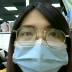

In [30]:
# while True:
clear_output()
frame, img = producer_live(cap)
consumer_live(accel, frame)
img
#     time.sleep(0.5)

Class name: Correctly Masked


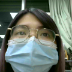

In [27]:
clear_output()
frame, img = producer_live(cap)
consumer_live(accel, frame)
img

Class name: No Mask


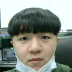

In [25]:
clear_output()
frame, img = producer_live(cap)
consumer_live(accel, frame)
img

## Release Webcam

In [10]:
cap.release()
cursor.close()
conn.close()